In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
%matplotlib inline

In [2]:
b = phoebe.load('bundles/after_samplers.bundle')

#### Clean residuals (remove points in eclipses)

In [3]:
t1 = b.get_value('times', dataset='lc01', context='dataset')
r1 = b.calculate_residuals(model='mcmc_noisenuis_model', dataset='lc01').value
f1 = b.get_value('fluxes', dataset='lc01', context='dataset')
s1 = b.get_value('sigmas', dataset='lc01', context='dataset')

t2 = b.get_value('times', dataset='lc02', context='dataset')
r2 = b.calculate_residuals(model='mcmc_noisenuis_model', dataset='lc02').value
f2 = b.get_value('fluxes', dataset='lc02', context='dataset')
s2 = b.get_value('sigmas', dataset='lc02', context='dataset')

In [4]:
def remove_eclipses(times, residuals, sigmas, t0, period, phases1, phases2):
    # determine extent of data wrt t0
    i0 = int((t0 - min(times))/period)-1
    i1 = int((max(times-t0))/period)+1
    
    times_new = times
    residuals_new = residuals
    sigmas_new = sigmas
    for i in range(i0,i1+1,1):
        condition_1 = (times_new < t0+(i+phases1[0])*period) | (times_new > t0+(i+phases1[1])*period)
        times_new = times_new[condition_1]
        residuals_new = residuals_new[condition_1]
        sigmas_new = sigmas_new[condition_1]
        
        condition_2 = (times_new < t0+(i+phases2[0])*period) | (times_new > t0+(i+phases2[1])*period)
        times_new = times_new[condition_2]
        residuals_new = residuals_new[condition_2]
        sigmas_new = sigmas_new[condition_2]
        
    return times_new, residuals_new, sigmas_new

In [8]:
t0 = b.get_value('t0_supconj', context='component')
period = b.get_value('period', component='binary', context='component')
[ecl_phs1, ecl_phs2] = b['fitted_values@lc_soln_lcgeom'].value[-1]

In [9]:
t1_new, r1_new, s1_new = remove_eclipses(t1, r1, s1, t0, period, ecl_phs1, ecl_phs2)
t2_new, r2_new, s2_new = remove_eclipses(t2, r2, s2, t0, period, ecl_phs1, ecl_phs2)

<ErrorbarContainer object of 3 artists>

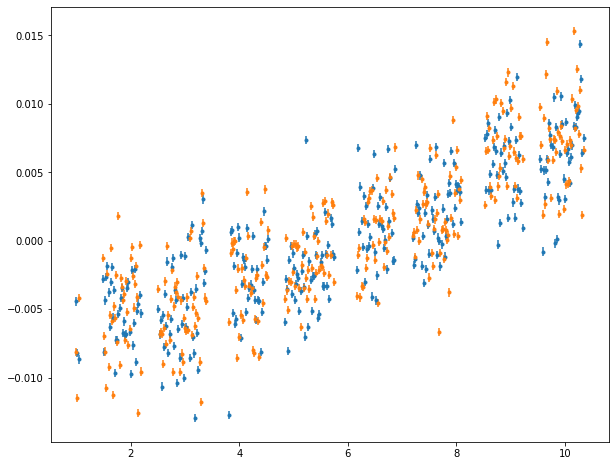

In [10]:
%matplotlib inline
plt.figure(figsize=(10,8))
plt.errorbar(x=t1_new,y=r1_new,yerr=s1_new, fmt='.')
plt.errorbar(x=t2_new,y=r2_new,yerr=s2_new, fmt='.')

### Grid search over kernels and optimized kernel parameters

In [15]:
from sklearn import gaussian_process as gp
from sklearn.gaussian_process.kernels import DotProduct, ExpSineSquared, WhiteKernel, RBF, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

plt.style.use('science')
plt.rc('legend', fontsize=8) 

In [29]:
len(t1_new)/3*2

212.0

In [30]:
# determine cutoff for training/test set
cutoff1 = 200
cutoff2 = 200

In [31]:
x1_train = t1_new[0:cutoff1]
x1_test = t1_new[cutoff1:]
y1_train = r1_new[0:cutoff1]
y1_test = r1_new[cutoff1:]

X1_train = x1_train.reshape(-1, 1)
X1_test = x1_test.reshape(-1,1)

x2_train = t2_new[0:cutoff2]
x2_test = t2_new[cutoff2:]
y2_train = r2_new[0:cutoff2]
y2_test = r2_new[cutoff2:]

X2_train = x2_train.reshape(-1, 1)
X2_test = x2_test.reshape(-1,1)

In [32]:
kernels = [WhiteKernel(noise_level_bounds=[1e-8,1]) + DotProduct(), 
           WhiteKernel(noise_level_bounds=[1e-8,1]) + ExpSineSquared(), 
           WhiteKernel(noise_level_bounds=[1e-8,1]) + RBF(), 
           WhiteKernel(noise_level_bounds=[1e-8,1]) + RationalQuadratic(),
           WhiteKernel(noise_level_bounds=[1e-8,1]) + DotProduct() + ExpSineSquared(),
           WhiteKernel(noise_level_bounds=[1e-8,1]) + DotProduct() + RBF(), 
           WhiteKernel(noise_level_bounds=[1e-8,1]) + DotProduct() + RationalQuadratic()]

In [33]:
kernel_labels = [
                 'WK + DP', 'WK + ESS', 'WK + RBF', 'WK+RQ', 
                 'WK + DP + ESS', 'WK + DP + RBF', 'WK + DP + RQ'
                ]

phoebe_c = {'black': "#131313",
             'blue': "#2B71B1",
             'orange': "#FF702F",
             'green': "#22B77F",
             'red': '#F92E3D',
             'purple': '#6D2EB8',
             'pink': "#ED3170",
             'yellow': "#FFCD2F"}

Calculating kernel.... WhiteKernel(noise_level=1) + DotProduct(sigma_0=1)
Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.79e-06) + DotProduct(sigma_0=0.0082)
Score:  0.06367719138442007


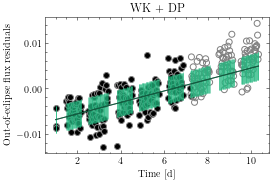

Calculating kernel.... WhiteKernel(noise_level=1) + ExpSineSquared(length_scale=1, periodicity=1)


/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.66e-06) + ExpSineSquared(length_scale=156, periodicity=30)
Score:  0.322521255520973


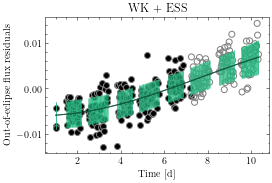

Calculating kernel.... WhiteKernel(noise_level=1) + RBF(length_scale=1)
Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.79e-06) + RBF(length_scale=787)
Score:  0.05619673085596011


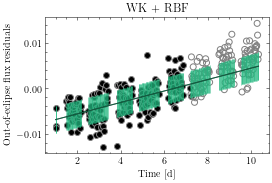

Calculating kernel.... WhiteKernel(noise_level=1) + RationalQuadratic(alpha=1, length_scale=1)


/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.66e-06) + RationalQuadratic(alpha=0.000139, length_scale=733)
Score:  0.3126226908479035


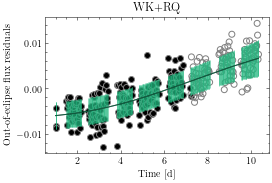

Calculating kernel.... WhiteKernel(noise_level=1) + DotProduct(sigma_0=1) + ExpSineSquared(length_scale=1, periodicity=1)
Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.34e-06) + DotProduct(sigma_0=0.0019) + ExpSineSquared(length_scale=1.48e+03, periodicity=2.45)
Score:  -0.02420596113823681


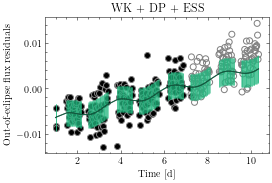

Calculating kernel.... WhiteKernel(noise_level=1) + DotProduct(sigma_0=1) + RBF(length_scale=1)
Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.66e-06) + DotProduct(sigma_0=0.0198) + RBF(length_scale=71)
Score:  0.2680663582310704


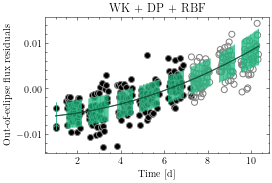

Calculating kernel.... WhiteKernel(noise_level=1) + DotProduct(sigma_0=1) + RationalQuadratic(alpha=1, length_scale=1)


/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.66e-06) + DotProduct(sigma_0=1e-05) + RationalQuadratic(alpha=1.41, length_scale=85)
Score:  0.2693718646695469


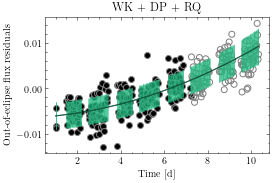

In [34]:
scores1 = []
kernels1_opt = []

for kernel, kernel_label in zip(kernels, kernel_labels):
    print('Calculating kernel....', kernel)
    gpr = GaussianProcessRegressor(kernel, n_restarts_optimizer= 3, random_state=42).fit(X1_train, y1_train)
    kernels1_opt.append(gpr.kernel_)
    scores1.append(gpr.score(X1_test, y1_test))
    print('Kernel with optimized hyperparameters: ', gpr.kernel_) 
    print('Score: ', scores1[-1])
    mu_skl, std_skl = gpr.predict(t1_new.reshape(-1,1), return_std=True)
    plt.figure(figsize=(4,2.5))
    plt.errorbar(t1_new, mu_skl, yerr=std_skl, capsize=0, alpha=0.5, c=phoebe_c['green'], rasterized=True)
    plt.plot(t1_new, mu_skl, 'k-', rasterized=True)
    plt.scatter(x1_train, y1_train, ec="grey",fc='black', rasterized=True)
    plt.scatter(x1_test, y1_test, ec="grey",fc='none', rasterized=True)
    plt.xlabel('Time [d]')
    plt.ylabel('Out-of-eclipse flux residuals')
    plt.title('%s' % kernel_label)
    # plt.savefig('figs/%s_1_noise.png' % kernel_label, dpi=300)
    plt.savefig('figs/gps/%s_1_noise.pdf' % kernel_label, dpi=300)
    plt.show()

Calculating kernel.... WhiteKernel(noise_level=1) + DotProduct(sigma_0=1)
Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.45e-06) + DotProduct(sigma_0=0.00833)
Score:  0.08453825195009868


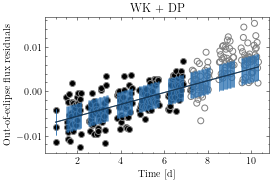

Calculating kernel.... WhiteKernel(noise_level=1) + ExpSineSquared(length_scale=1, periodicity=1)


/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.45e-06) + ExpSineSquared(length_scale=0.185, periodicity=2.54e+04)
Score:  0.07896836943231189


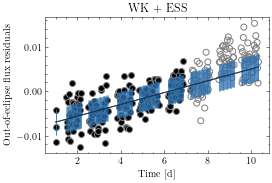

Calculating kernel.... WhiteKernel(noise_level=1) + RBF(length_scale=1)


/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.45e-06) + RBF(length_scale=747)
Score:  0.07896605096186748


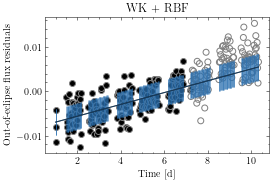

Calculating kernel.... WhiteKernel(noise_level=1) + RationalQuadratic(alpha=1, length_scale=1)
Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.37e-06) + RationalQuadratic(alpha=0.000235, length_scale=715)
Score:  0.30512186235056304


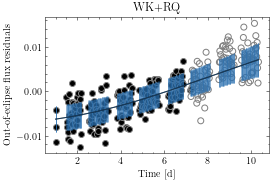

Calculating kernel.... WhiteKernel(noise_level=1) + DotProduct(sigma_0=1) + ExpSineSquared(length_scale=1, periodicity=1)


/Users/angela/miniconda3/envs/phoebe_2.4/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.23e-06) + DotProduct(sigma_0=1e-05) + ExpSineSquared(length_scale=2.12e+03, periodicity=1.66)
Score:  0.09813626208852366


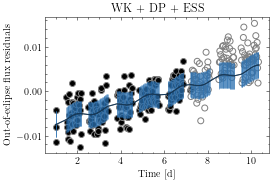

Calculating kernel.... WhiteKernel(noise_level=1) + DotProduct(sigma_0=1) + RBF(length_scale=1)
Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.36e-06) + DotProduct(sigma_0=0.0267) + RBF(length_scale=79.4)
Score:  0.3564391168345945


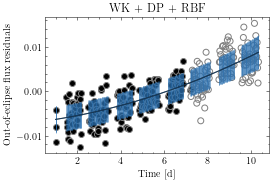

Calculating kernel.... WhiteKernel(noise_level=1) + DotProduct(sigma_0=1) + RationalQuadratic(alpha=1, length_scale=1)
Kernel with optimized hyperparameters:  WhiteKernel(noise_level=8.36e-06) + DotProduct(sigma_0=0.000363) + RationalQuadratic(alpha=829, length_scale=79.4)
Score:  0.35644192061540303


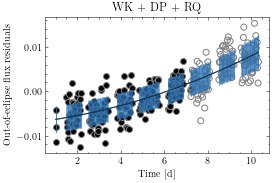

In [35]:
scores2 = []
kernels2_opt = []

for kernel, kernel_label in zip(kernels, kernel_labels):
    print('Calculating kernel....', kernel)
    gpr = GaussianProcessRegressor(kernel, n_restarts_optimizer= 3, random_state=42).fit(X2_train, y2_train)
    kernels2_opt.append(gpr.kernel_)
    scores2.append(gpr.score(X2_test, y2_test))
    print('Kernel with optimized hyperparameters: ', gpr.kernel_) 
    print('Score: ', scores2[-1])
    mu_skl, std_skl = gpr.predict(t2_new.reshape(-1,1), return_std=True)
    plt.figure(figsize=(4,2.5))
    plt.errorbar(t2_new, mu_skl, yerr=std_skl, capsize=0, alpha=0.5, c=phoebe_c['blue'], rasterized=True)
    plt.plot(t2_new, mu_skl, 'k-', rasterized=True)
    plt.scatter(x2_train, y2_train, ec="grey",fc='black', rasterized=True)
    plt.scatter(x2_test, y2_test, ec="grey",fc='none', rasterized=True)
    plt.xlabel('Time [d]')
    plt.ylabel('Out-of-eclipse flux residuals')
    plt.title('%s' % kernel_label)
    # plt.savefig('figs/%s_2.png' % kernel_label, dpi=300)
    plt.savefig('figs/gps/%s_2_noise.pdf' % kernel_label, dpi=300)
    plt.show()

In [36]:
kernels1_opt = np.array(kernels1_opt)
scores1 = np.array(scores1)
kernels2_opt = np.array(kernels2_opt)
scores2 = np.array(scores2)

In [45]:
for score, kernel in zip(scores1[np.argsort(scores1)], kernels1_opt[np.argsort(scores1)]):
    print(kernel, score)

WhiteKernel(noise_level=8.34e-06) + DotProduct(sigma_0=0.0019) + ExpSineSquared(length_scale=1.48e+03, periodicity=2.45) -0.02420596113823681
WhiteKernel(noise_level=8.79e-06) + RBF(length_scale=787) 0.05619673085596011
WhiteKernel(noise_level=8.79e-06) + DotProduct(sigma_0=0.0082) 0.06367719138442007
WhiteKernel(noise_level=8.66e-06) + DotProduct(sigma_0=0.0198) + RBF(length_scale=71) 0.2680663582310704
WhiteKernel(noise_level=8.66e-06) + DotProduct(sigma_0=1e-05) + RationalQuadratic(alpha=1.41, length_scale=85) 0.2693718646695469
WhiteKernel(noise_level=8.66e-06) + RationalQuadratic(alpha=0.000139, length_scale=733) 0.3126226908479035
WhiteKernel(noise_level=8.66e-06) + ExpSineSquared(length_scale=156, periodicity=30) 0.322521255520973


In [38]:
for score, kernel in zip(scores2[np.argsort(scores2)], kernels2_opt[np.argsort(scores2)]):
    print(kernel, score)

WhiteKernel(noise_level=8.45e-06) + RBF(length_scale=747) 0.07896605096186748
WhiteKernel(noise_level=8.45e-06) + ExpSineSquared(length_scale=0.185, periodicity=2.54e+04) 0.07896836943231189
WhiteKernel(noise_level=8.45e-06) + DotProduct(sigma_0=0.00833) 0.08453825195009868
WhiteKernel(noise_level=8.23e-06) + DotProduct(sigma_0=1e-05) + ExpSineSquared(length_scale=2.12e+03, periodicity=1.66) 0.09813626208852366
WhiteKernel(noise_level=8.37e-06) + RationalQuadratic(alpha=0.000235, length_scale=715) 0.30512186235056304
WhiteKernel(noise_level=8.36e-06) + DotProduct(sigma_0=0.0267) + RBF(length_scale=79.4) 0.3564391168345945
WhiteKernel(noise_level=8.36e-06) + DotProduct(sigma_0=0.000363) + RationalQuadratic(alpha=829, length_scale=79.4) 0.35644192061540303


### Detrend light curves

In [40]:
kernel1 = RationalQuadratic(alpha=0.000139, length_scale=733, alpha_bounds='fixed', length_scale_bounds='fixed')
kernel2 = RationalQuadratic(alpha=0.000235, length_scale=715, alpha_bounds='fixed', length_scale_bounds='fixed')

gpr1 = GaussianProcessRegressor(kernel1, n_restarts_optimizer= 3, random_state=42).fit(t1_new.reshape(-1,1), r1_new)
y_predicted1 = gpr1.predict(t1.reshape(-1,1))

gpr2 = GaussianProcessRegressor(kernel2, n_restarts_optimizer= 3, random_state=42).fit(t2_new.reshape(-1,1), r2_new)
y_predicted2 = gpr2.predict(t2.reshape(-1,1))

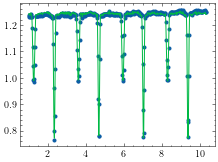

In [42]:
plt.plot(t1, f1, '.')
plt.plot(t1, f1-y_predicted1, '-')

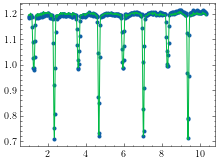

In [43]:
plt.plot(t2, f2, '.')
plt.plot(t2, f2-y_predicted2, '-')

In [44]:
np.savetxt('data/lc.V.data.dtr.rq', np.array([t1, f1-y_predicted1, s1]).T)
np.savetxt('data/lc.B.data.dtr.rq', np.array([t2, f2-y_predicted2, s2]).T)

# Hyperparameter GS for prior boundaries

In [59]:
# alphas = np.linspace(0, 1e-3, 100)
length_scales = np.linspace(100, 3100, 3000)
scores1 = np.zeros((3000, 3))
scores2 = np.zeros((3000, 3))

In [60]:
X1 = t1.reshape(-1,1)
y1 = r1
X2 = t2.reshape(-1,1)
y2 = r2

In [61]:
i=0
# for alpha in alphas:
for length_scale in length_scales:
    # kernel.alpha = alpha
    kernel1.length_scale = length_scale
    gpr = GaussianProcessRegressor(kernel1, n_restarts_optimizer= 3, random_state=42).fit(X1, y1)
    y_predicted = gpr.predict(X1)
    scores1[i] = [length_scale, np.sum((y_predicted-y1)**2), np.mean(np.abs(y_predicted-y1))]
    print(i, length_scale, scores1[i])
    i+=1

0 100.0 [1.00000000e+02 3.49603822e-03 2.20051622e-03]
1 101.0003334444815 [1.01000333e+02 3.49838083e-03 2.20152143e-03]
2 102.00066688896298 [1.02000667e+02 3.50061020e-03 2.20243747e-03]
3 103.00100033344448 [1.03001000e+02 3.50285347e-03 2.20330526e-03]
4 104.00133377792598 [1.04001334e+02 3.50504568e-03 2.20411786e-03]
5 105.00166722240746 [1.05001667e+02 3.50722562e-03 2.20487987e-03]
6 106.00200066688896 [1.06002001e+02 3.50933988e-03 2.20563933e-03]
7 107.00233411137046 [1.07002334e+02 3.51140297e-03 2.20635641e-03]
8 108.00266755585196 [1.08002668e+02 3.51347278e-03 2.20704954e-03]
9 109.00300100033344 [1.09003001e+02 3.51548415e-03 2.20769927e-03]
10 110.00333444481494 [1.10003334e+02 3.51737241e-03 2.20829089e-03]
11 111.00366788929642 [1.11003668e+02 3.51926949e-03 2.20887152e-03]
12 112.00400133377792 [1.12004001e+02 3.52103927e-03 2.20941141e-03]
13 113.00433477825942 [1.13004335e+02 3.52272710e-03 2.20992683e-03]
14 114.00466822274092 [1.14004668e+02 3.52437983e-03 2.210

In [62]:
i=0
# for alpha in alphas:
for length_scale in length_scales:
    # kernel.alpha = alpha
    kernel2.length_scale = length_scale
    gpr = GaussianProcessRegressor(kernel2, n_restarts_optimizer= 3, random_state=42).fit(X2, y2)
    y_predicted = gpr.predict(X2)
    scores2[i] = [length_scale, np.sum((y_predicted-y2)**2), np.mean(np.abs(y_predicted-y2))]
    print(i, length_scale, scores1[i])
    i+=1

0 100.0 [1.00000000e+02 3.49603822e-03 2.20051622e-03]
1 101.0003334444815 [1.01000333e+02 3.49838083e-03 2.20152143e-03]
2 102.00066688896298 [1.02000667e+02 3.50061020e-03 2.20243747e-03]
3 103.00100033344448 [1.03001000e+02 3.50285347e-03 2.20330526e-03]
4 104.00133377792598 [1.04001334e+02 3.50504568e-03 2.20411786e-03]
5 105.00166722240746 [1.05001667e+02 3.50722562e-03 2.20487987e-03]
6 106.00200066688896 [1.06002001e+02 3.50933988e-03 2.20563933e-03]
7 107.00233411137046 [1.07002334e+02 3.51140297e-03 2.20635641e-03]
8 108.00266755585196 [1.08002668e+02 3.51347278e-03 2.20704954e-03]
9 109.00300100033344 [1.09003001e+02 3.51548415e-03 2.20769927e-03]
10 110.00333444481494 [1.10003334e+02 3.51737241e-03 2.20829089e-03]
11 111.00366788929642 [1.11003668e+02 3.51926949e-03 2.20887152e-03]
12 112.00400133377792 [1.12004001e+02 3.52103927e-03 2.20941141e-03]
13 113.00433477825942 [1.13004335e+02 3.52272710e-03 2.20992683e-03]
14 114.00466822274092 [1.14004668e+02 3.52437983e-03 2.210

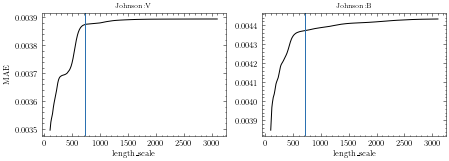

In [65]:
%matplotlib inline
plt.style.use('science')
plt.rcParams.update({'font.size': 8})
plt.rcParams.update({'figure.titlesize': 'small'})
plt.rcParams.update({'axes.titlesize': 'small'})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7.25, 2.25))
axes[0].plot(scores1[:,0], scores1[:,1], 'k', rasterized=True)
axes[1].plot(scores2[:,0], scores2[:,1], 'k', rasterized=True)
axes[0].set_xlabel('length_scale')
axes[1].set_xlabel('length_scale')
axes[0].set_ylabel('MAE')
axes[0].set_title('Johnson:V')
axes[1].set_title('Johnson:B')
# axes[0].axvline(x=30, ls='--', c=phoebe_c['red'])
# axes[0].axvline(x=500, ls='--', c=phoebe_c['red'])
# axes[1].axvline(x=80, ls='--', c=phoebe_c['red'])
# axes[1].axvline(x=500, ls='--', c=phoebe_c['red'])
axes[0].axvline(x=733, ls='-', c=phoebe_c['blue'])
axes[1].axvline(x=715, ls='-', c=phoebe_c['blue'])
fig.savefig('figs/gps_mae_rq.pdf', dpi=300)
# plt.axhline(y=np.log10(2.8619999999999997e-05), c='r')